# Pneumonia Classification
Project by Maria Kaltenbrunner and Mohamed Goha
<br>for Computer Vision (FH Technikum) Fall 2020

## What is our project?
We want to train a model which is able to classify y-ray images of lungs into pneumonic and non-pneumonic. 

## What is Pneumonia?

In [1]:
import os
import matplotlib as plt
import numpy as np
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.enable_eager_execution()
from tensorflow.python.framework import ops
#ops.reset_default_graph()
#from tensorflow.keras import datasets, layers, models
#from keras.constraints import maxnorm
#import keras
from keras.backend import clear_session
from keras.datasets import mnist
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import MaxPooling2D
from keras.models import Sequential
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import datetime
import optuna
from imblearn.over_sampling import SMOTE
import pandas as pd
from pathlib import Path
import seaborn as sns
from skimage.io import imread
from skimage.transform import resize
from keras.utils import to_categorical

Instructions for updating:
non-resource variables are not supported in the long term


## Description of the Pneumonia Dataset

![0_basic_data_structure.png](documentation/images/0_basic_data_structure.png)

## Loading the Dataset

In [2]:
data_dir = Path('data')

# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = data_dir / 'train'

# Path to validation directory
val_dir = data_dir / 'val'

# Path to test directory
test_dir = data_dir / 'test'

In [3]:
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    train_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head()
print(train_data.shape)

(5216, 2)


1    3875
0    1341
Name: label, dtype: int64


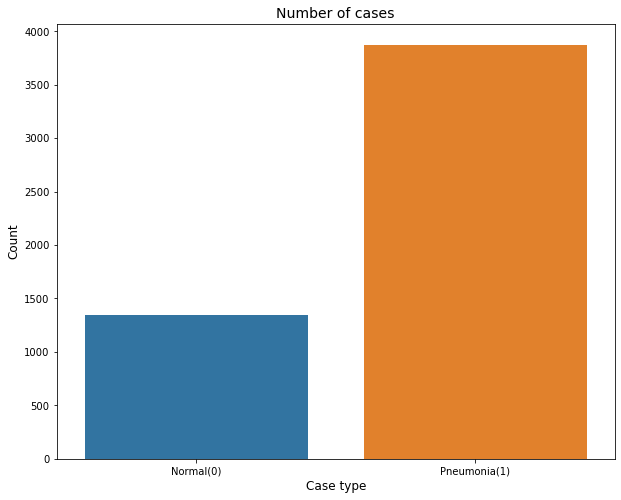

In [4]:
# Get the counts for each class
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

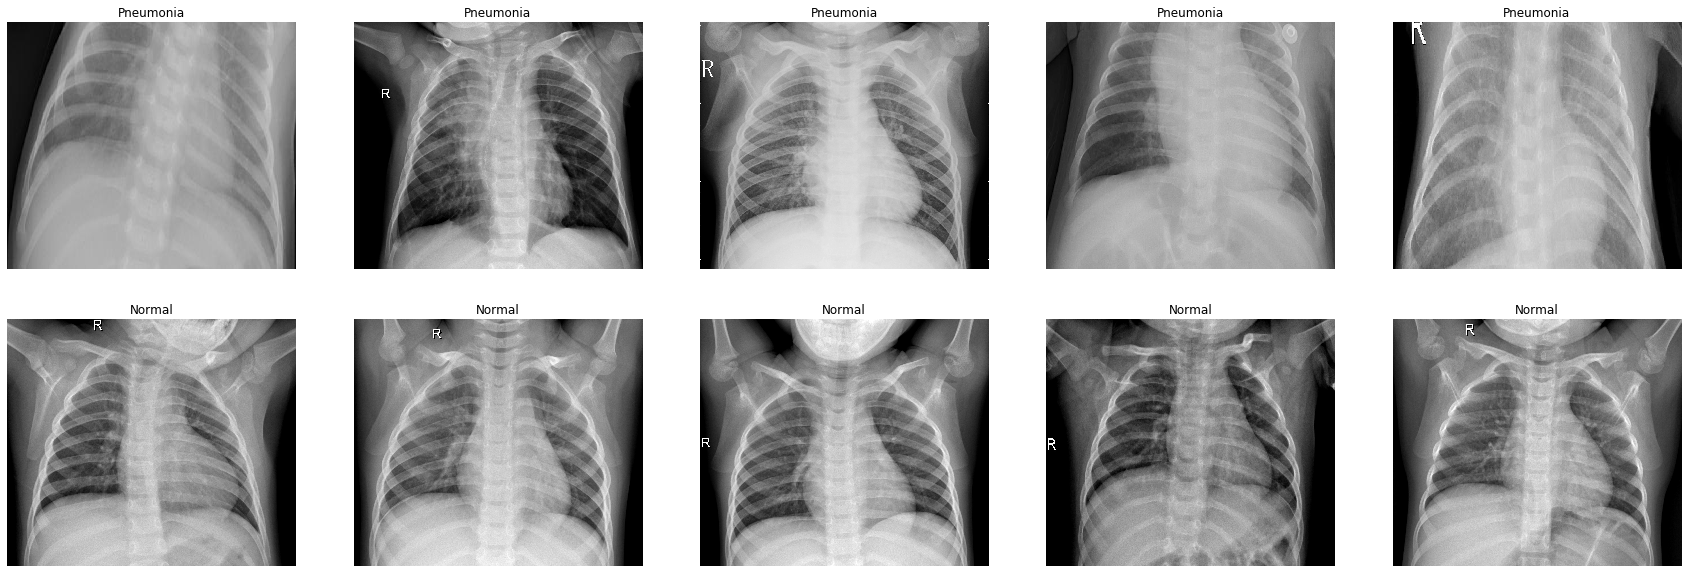

In [17]:
# Get few samples for both the classes
pneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

In [6]:
def load_images(data_dir, folder, img_size, color = False):
    """
    Loads images from a folder, resizes them and stores them in a numpy array.
   
    Parameters:
    data_dir -- string, the path to to the main data folder
    img_size: integer, to this value the loaded images are resized before returned
    
    Returns:
    data -- list of numpy arrays, containing data and labels of train, test and validation
    """
    data_dir = os.path.join(data_dir, folder)
    label_folders = os.listdir(data_dir)
    colors = {True: cv2.IMREAD_COLOR, False: cv2.IMREAD_GRAYSCALE}

    images_original = []
    string_labels = []
    for folder in label_folders:
        folder_path = os.path.join(data_dir, folder)
        filenames = os.listdir(folder_path)
        filepaths = [os.path.join(folder_path, name) for name in filenames]
        images_original += [cv2.imread(file, colors[color]) for file in filepaths]
        images_resized = [cv2.resize(img, (img_size, img_size)) for img in images_original]
        string_labels += [folder for _ in filenames]
    
    final_images = []
    for img in images_resized:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32)/255.
            final_images.append(img)
            
    return (np.array(final_images), np.array(string_labels))

In [7]:
data_dir = 'data'
folders = os.listdir(data_dir)

train_X, train_y = load_images(data_dir, folders[1], 50)
test_X, test_y =  load_images(data_dir, folders[0], 50)
#val_X, val_y = load_images(data_dir, folders[2], 100)

print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(5216, 50, 50, 3)
(5216,)
(624, 50, 50, 3)
(624,)


In [ ]:
# data augmentation
# train_y = np.expand_dims(train_y, axis=1)
# nsamples, nx, ny = train_X.shape
# train_X = train_X.reshape((nsamples,nx*ny))
# sm = SMOTE()
# train_X, train_y = sm.fit_sample(train_X,train_y)
# train_X = train_X.reshape((train_X.shape[0],nx,ny))

In [9]:
#not necessary anymore
# print(train_X.shape)

# train_X = np.expand_dims(train_X, axis=3)
# test_X = np.expand_dims(test_X, axis=3)
# train_X = tf.image.resize(train_X, [50,50]).numpy()
# test_X = tf.image.resize(test_X, [50,50]).numpy()
#train_y = np.expand_dims(train_y, axis=1)
#test_y = np.expand_dims(test_y, axis=1)

print('shapes:')
print('training data: ', train_X.shape)
print('test data: ', test_X.shape)

#print('validation data: ', val_X.shape)

print('training labels: ', train_y.shape)
print('test labels: ', test_y.shape)
#print('validation labels: ',val_y.shape)

print('training label strings: ',np.unique(train_y))
print('testing labels strings: ', np.unique(test_y))
#print('validation label strings', np.unique(val_y))

shapes:
training data:  (5216, 50, 50, 3)
test data:  (624, 50, 50, 3)
training labels:  (5216,)
test labels:  (624,)
training label strings:  ['NORMAL' 'PNEUMONIA']
testing labels strings:  ['NORMAL' 'PNEUMONIA']


## One-Hot Encoding

In [10]:
#train_X = np.array(train_X)/255
#val_X = np.array(val_X)/255
#test_X = np.array(test_X)/255
#print(train_X[0])
#print(val_X[0])
#print(test_X[0])

test_Y = []
counter = 0
counter1 = 0
for label in test_y:
    if label == 'NORMAL':
        counter += 1
        #test_Y = np.append(test_Y, 0)
        test_Y.append(to_categorical(0, num_classes=2))
    elif label == 'PNEUMONIA':
        counter1 += 1
        #test_Y = np.append(test_Y, 1)
        test_Y.append(to_categorical(1, num_classes=2))
test_Y = np.array(test_Y)
test_y = test_Y
print(test_Y[:10])
print('number of normal cases in test data: ',counter )
print('number of pneumonia cases in test data: ',counter1 )
train_Y = []
counter = 0
counter1 = 0
for label in train_y:
    if label == 'NORMAL':
        counter += 1
        #train_Y = np.append(train_Y, 0)
        train_Y.append(to_categorical(0, num_classes=2))
    elif label == 'PNEUMONIA':
        counter1 += 1
        #train_Y = np.append(train_Y, 1)
        train_Y.append(to_categorical(1, num_classes=2))
train_Y = np.array(train_Y)
print('shape: ',train_Y.shape)
train_y = train_Y
print(train_Y[:10])
print('number of normal cases in train data: ',counter )
print('number of pneumonia cases in train data: ',counter1 )

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
number of normal cases in test data:  234
number of pneumonia cases in test data:  390
shape:  (5216, 2)
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
number of normal cases in train data:  1341
number of pneumonia cases in train data:  3875


## Hyperparameter optimization

In [11]:
BATCHSIZE = 1000
EPOCHS = 5

def objective(trial):
    # Clear clutter from previous Keras session graphs.
    clear_session()

    input_shape = (train_X.shape[1],train_X.shape[2],train_X.shape[3])
    
    model = Sequential()
    model.add(
        Conv2D(
            filters=trial.suggest_categorical("filters", [6, 20]),
            kernel_size=trial.suggest_categorical("kernel_size", [3, 5]),
            strides=trial.suggest_categorical("strides", [1, 2]),
            activation=trial.suggest_categorical("activation", ["relu"]),
            input_shape=input_shape,
        )
    )
    model.add(MaxPooling2D((2, 2)))
    model.add(
        Conv2D(
            filters=trial.suggest_categorical("filters2", [16, 30]),
            kernel_size=trial.suggest_categorical("kernel_size2", [3, 5]),
            strides=trial.suggest_categorical("strides2", [1, 2]),
            activation=trial.suggest_categorical("activation2", ["relu"]),
            #input_shape=input_shape,
        )
    )
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(trial.suggest_categorical("nodeslayer1", [512,1024]), activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(trial.suggest_categorical("nodeslayer2", [128,200]), activation="relu"))
    model.add(Dense(2, activation="sigmoid"))

    # We compile our model with a sampled learning rate.
    #lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    model.compile(
        loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"]
    )

    model.fit(
        train_X,
        train_y,
        validation_data=(test_X, test_y),
        shuffle=True,
        batch_size=BATCHSIZE,
        epochs=EPOCHS,
        verbose=False,
    )

    # Evaluate the model accuracy on the validation set.
    score = model.evaluate(test_X, test_y, verbose=0)
    return score[1]

In [12]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2020-12-29 08:25:49,063] A new study created in memory with name: no-name-ba0ca72d-5505-4bba-927e-065c555f940c
[I 2020-12-29 08:25:55,390] Trial 0 finished with value: 0.625 and parameters: {'filters': 6, 'kernel_size': 3, 'strides': 2, 'activation': 'relu', 'filters2': 16, 'kernel_size2': 3, 'strides2': 2, 'activation2': 'relu', 'nodeslayer1': 1024, 'nodeslayer2': 128}. Best is trial 0 with value: 0.625.
[I 2020-12-29 08:26:11,051] Trial 1 finished with value: 0.8381410241127014 and parameters: {'filters': 6, 'kernel_size': 3, 'strides': 1, 'activation': 'relu', 'filters2': 16, 'kernel_size2': 3, 'strides2': 1, 'activation2': 'relu', 'nodeslayer1': 512, 'nodeslayer2': 128}. Best is trial 1 with value: 0.8381410241127014.
[I 2020-12-29 08:26:48,614] Trial 2 finished with value: 0.8365384340286255 and parameters: {'filters': 20, 'kernel_size': 5, 'strides': 1, 'activation': 'relu', 'filters2': 16, 'kernel_size2': 5, 'strides2': 1, 'activation2': 'relu', 'nodeslayer1': 1024, 'nodeslay

[I 2020-12-29 08:34:11,141] Trial 25 finished with value: 0.7243589758872986 and parameters: {'filters': 6, 'kernel_size': 3, 'strides': 2, 'activation': 'relu', 'filters2': 30, 'kernel_size2': 5, 'strides2': 1, 'activation2': 'relu', 'nodeslayer1': 512, 'nodeslayer2': 200}. Best is trial 12 with value: 0.8621794581413269.
[I 2020-12-29 08:34:36,031] Trial 26 finished with value: 0.7419871687889099 and parameters: {'filters': 6, 'kernel_size': 5, 'strides': 1, 'activation': 'relu', 'filters2': 30, 'kernel_size2': 5, 'strides2': 2, 'activation2': 'relu', 'nodeslayer1': 512, 'nodeslayer2': 200}. Best is trial 12 with value: 0.8621794581413269.
[I 2020-12-29 08:34:46,127] Trial 27 finished with value: 0.7980769276618958 and parameters: {'filters': 20, 'kernel_size': 3, 'strides': 2, 'activation': 'relu', 'filters2': 16, 'kernel_size2': 3, 'strides2': 1, 'activation2': 'relu', 'nodeslayer1': 1024, 'nodeslayer2': 200}. Best is trial 12 with value: 0.8621794581413269.
[I 2020-12-29 08:35:08,

Number of finished trials: 33
Best trial:
  Value: 0.8669871687889099
  Params: 
    filters: 6
    kernel_size: 3
    strides: 1
    activation: relu
    filters2: 16
    kernel_size2: 5
    strides2: 1
    activation2: relu
    nodeslayer1: 512
    nodeslayer2: 200


## Building the model with optimized hyperparameters

In [13]:
clear_session()
model = Sequential()
model.add(Conv2D(6, (3, 3), strides=(1,1), activation='relu', input_shape=(50, 50, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(16, (5, 5), strides=(1,1), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(200, activation='relu'))
model.add(Dense(2, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 6)         168       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 16)        2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               8

In [14]:
BATCHSIZE = 1000
EPOCHS = 100
model.compile(
        loss="binary_crossentropy", optimizer='adam', metrics=['accuracy',"Recall","Precision"]
    )

history = model.fit(
        train_X,
        train_y,
        validation_data=(test_X, test_y),
        shuffle=True,
        batch_size=BATCHSIZE,
        epochs=EPOCHS,
        verbose=1,
        )

Epoch 1/100
6/6 [==============================] - 3s 513ms/step - loss: 0.6165 - accuracy: 0.7126 - recall: 0.7678 - precision: 0.6797 - val_loss: 0.6696 - val_accuracy: 0.6250 - val_recall: 0.6250 - val_precision: 0.6250
Epoch 2/100
6/6 [==============================] - 2s 409ms/step - loss: 0.5372 - accuracy: 0.7429 - recall: 0.7429 - precision: 0.7429 - val_loss: 0.5771 - val_accuracy: 0.6426 - val_recall: 0.6234 - val_precision: 0.6473
Epoch 3/100
6/6 [==============================] - 2s 406ms/step - loss: 0.4415 - accuracy: 0.7757 - recall: 0.7615 - precision: 0.7844 - val_loss: 0.4897 - val_accuracy: 0.7324 - val_recall: 0.7179 - val_precision: 0.7405
Epoch 4/100
6/6 [==============================] - 3s 431ms/step - loss: 0.3310 - accuracy: 0.8591 - recall: 0.8560 - precision: 0.8601 - val_loss: 0.5310 - val_accuracy: 0.7404 - val_recall: 0.7436 - val_precision: 0.7389
Epoch 5/100
6/6 [==============================] - 3s 439ms/step - loss: 0.2682 - accuracy: 0.8832 - recall:

Epoch 38/100
6/6 [==============================] - 4s 598ms/step - loss: 0.0602 - accuracy: 0.9772 - recall: 0.9772 - precision: 0.9774 - val_loss: 0.8170 - val_accuracy: 0.7676 - val_recall: 0.7676 - val_precision: 0.7676
Epoch 39/100
6/6 [==============================] - 3s 576ms/step - loss: 0.0591 - accuracy: 0.9770 - recall: 0.9772 - precision: 0.9768 - val_loss: 0.7452 - val_accuracy: 0.7837 - val_recall: 0.7837 - val_precision: 0.7837
Epoch 40/100
6/6 [==============================] - 3s 548ms/step - loss: 0.0544 - accuracy: 0.9799 - recall: 0.9795 - precision: 0.9800 - val_loss: 0.9070 - val_accuracy: 0.7596 - val_recall: 0.7596 - val_precision: 0.7596
Epoch 41/100
6/6 [==============================] - 3s 557ms/step - loss: 0.0504 - accuracy: 0.9812 - recall: 0.9814 - precision: 0.9807 - val_loss: 0.8685 - val_accuracy: 0.7740 - val_recall: 0.7756 - val_precision: 0.7744
Epoch 42/100
6/6 [==============================] - 3s 568ms/step - loss: 0.0532 - accuracy: 0.9826 - re

6/6 [==============================] - 3s 566ms/step - loss: 0.0201 - accuracy: 0.9933 - recall: 0.9931 - precision: 0.9933 - val_loss: 1.1880 - val_accuracy: 0.7564 - val_recall: 0.7564 - val_precision: 0.7564
Epoch 75/100
6/6 [==============================] - 3s 555ms/step - loss: 0.0202 - accuracy: 0.9939 - recall: 0.9941 - precision: 0.9939 - val_loss: 1.1705 - val_accuracy: 0.7692 - val_recall: 0.7692 - val_precision: 0.7692
Epoch 76/100
6/6 [==============================] - 3s 561ms/step - loss: 0.0167 - accuracy: 0.9941 - recall: 0.9941 - precision: 0.9939 - val_loss: 1.1539 - val_accuracy: 0.7676 - val_recall: 0.7692 - val_precision: 0.7680
Epoch 77/100
6/6 [==============================] - 3s 552ms/step - loss: 0.0203 - accuracy: 0.9923 - recall: 0.9925 - precision: 0.9923 - val_loss: 1.6170 - val_accuracy: 0.7244 - val_recall: 0.7244 - val_precision: 0.7244
Epoch 78/100
6/6 [==============================] - 3s 556ms/step - loss: 0.0261 - accuracy: 0.9887 - recall: 0.9889 

20/20 - 0s - loss: 1.6178 - accuracy: 0.7564 - recall: 0.7564 - precision: 0.7564


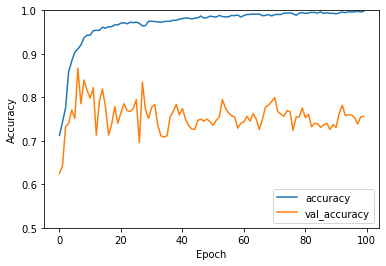

In [16]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc, test_recall, test_precision = model.evaluate(test_X,  test_y, verbose=2)

In [18]:
pip freeze > requirements_momo.txt

Note: you may need to restart the kernel to use updated packages.


In [ ]:
CONV1_f = 3
CONV1_n = 6
CONV2_f = 3
CONV2_n = 16
FULL1_n = 512
FULL2_n = 128

class CNN:
    def __init__(self, num_classes, image_height, image_width, image_channels, batch_size, learning_rate):

        self.input = tf.placeholder(tf.float32, shape=(batch_size, image_height, image_width, image_channels), name='input')
        
        if(num_classes > 2):
            self.output = tf.placeholder(tf.float32, shape=[batch_size, num_classes], name='output')
        else:
            self.output = tf.placeholder(tf.float32, shape=[batch_size, 1], name='output')
            
        self.num = tf.placeholder(tf.int32)
        
        #first convolutional layer
        kernel1 = tf.Variable(tf.random_normal([CONV1_f, CONV1_f, image_channels, CONV1_n]))
        self.cl1_k = tf.nn.conv2d(self.input, kernel1, strides= 1, padding='VALID')
        self.cl1_b = tf.Variable(tf.random_normal([1, CONV1_n]))
        self.cl1_z = tf.add(self.cl1_k, self.cl1_b)
        self.cl1_a = tf.nn.relu(self.cl1_z)
        self.cl1_output = tf.nn.max_pool(self.cl1_a, ksize=[ 1, 2, 2, 1 ], strides=[ 1, 2, 2, 1 ], padding = 'VALID')
        
        #second convolutional layer
        kernel2 = tf.Variable(tf.random_normal([CONV2_f, CONV2_f, self.cl1_output.shape[3], CONV2_n]))
        self.cl2_k = tf.nn.conv2d(self.cl1_output, kernel2, strides= 1, padding='VALID')
        self.cl2_b = tf.Variable(tf.random_normal([1, CONV2_n]))
        self.cl2_z = tf.add(self.cl2_k, self.cl2_b)
        self.cl2_a = tf.nn.relu(self.cl2_z)
        self.cl2_output = tf.nn.max_pool(self.cl2_a, ksize=[ 1, 2, 2, 1 ], strides=[ 1, 2, 2, 1 ], padding = 'VALID')
        
        self.cl2_output = tf.reshape(self.cl2_output, [batch_size, -1])
        
        # two fully connected layers
        if num_classes > 2:
            self.layersizes = [self.cl2_output.shape[1],FULL1_n,FULL2_n,num_classes]
        else:
            self.layersizes = [self.cl2_output.shape[1],FULL1_n,FULL2_n,1]
        self.W = []
        self.B = []
        self.Z = []
        self.A = []
        self.W.append(None)
        self.B.append(None)
        self.Z.append(None)
        self.A.append(self.cl2_output)
        
        for x in range(1,len(self.layersizes)):
            self.W.append(tf.Variable(tf.random_normal([self.layersizes[x-1], self.layersizes[x]])))
            self.B.append(tf.Variable(tf.random_normal([1, self.layersizes[x]])))
            self.Z.append(tf.add(tf.matmul(self.A[x-1], self.W[x]), self.B[x]))
            self.A.append(tf.nn.relu(self.Z[x]))
            
        # set up the final layer
        if num_classes > 2:
            
            self.prediction = tf.nn.softmax(self.Z[-1])
            self.loss = tf.reduce_sum(
            tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.output, logits=self.Z[-1], name='cost')/tf.cast(self.num, tf.float32))
            self.train_step = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)
            
            equal = tf.equal(
                            tf.argmax(self.prediction[0:self.num], 1),
                            tf.argmax(self.output[0:self.num], 1),)
            self.num_correct = tf.reduce_sum(tf.cast(equal, tf.float32), name='accuracy_computation')
            
        else:
            
            self.prediction = tf.nn.sigmoid(self.Z[-1])
            self.loss = tf.reduce_sum(
            tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=self.output, logits=self.Z[-1], name='cost')/tf.cast(self.num, tf.float32)))
            self.train_step = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)
            
            equal = tf.equal(
                             tf.cast(self.output[0:self.num], tf.bool),
                             tf.cast(tf.round(self.prediction[0:self.num]), tf.bool),)
            self.num_correct = tf.reduce_sum(tf.cast(equal, tf.float32), name='accuracy_computation')

        self.init = tf.global_variables_initializer()

In [ ]:
tf.disable_eager_execution()
tf.reset_default_graph()
cats_image_height = train_X.shape[1]
cats_image_width = train_X.shape[2]
cats_image_channels = 1
cats_batch_size = train_X.shape[0] # use all images at once, no real batching
cats_epochs = 100
cats_learning_rate = 0.02
model = CNN(2, cats_image_width, cats_image_width, cats_image_channels, cats_batch_size, cats_learning_rate)

with tf.Session() as sess:
    sess.run(model.init)
    nowstr = datetime.datetime.now().strftime('%Y-%m-%d_%H.%M.%S')
    train_writer = tf.summary.FileWriter('cat_cnn_summaries/%s_train' % nowstr, sess.graph)
    test_writer = tf.summary.FileWriter('cat_cnn_summaries/%s_test' % nowstr)

    train_fd = {
        model.num: cats_batch_size,
        model.input: train_X,
        model.output: train_y,
    }
    # the test data does not fill a complete batch, fill the rest up with zeros
    missing = cats_batch_size - test_X.shape[0]
    padded_test_x = np.pad(test_X, [ (0, missing), (0, 0), (0, 0), (0,0) ], 'constant')
    padded_test_y = np.pad(test_y, [ (0, missing),(0,0) ], 'constant')
    print(padded_test_x.shape)
    print(padded_test_y.shape)
    test_fd = {
        model.num: test_X.shape[0],
        model.input: padded_test_x,
        model.output: padded_test_y,
        #model.input: test_X,
        #model.output: test_y,
    }
    
    for epoch in range(1, cats_epochs+1):

        _ = sess.run(model.train_step, feed_dict=train_fd)

        if epoch % 5 == 0:
            train_loss, train_correct = sess.run(
                [ model.loss, model.num_correct ],
                feed_dict=train_fd
            )
            train_acc = train_correct / cats_batch_size
            summary = tf.Summary()
            summary.value.add(tag='loss', simple_value=train_loss)
            train_writer.add_summary(summary, epoch)
            summary = tf.Summary()
            summary.value.add(tag='accuracy', simple_value=train_acc)
            train_writer.add_summary(summary, epoch)
            train_writer.flush()

            test_loss, test_correct = sess.run(
                [ model.loss, model.num_correct ],
                feed_dict=test_fd
            )
            test_acc = test_correct / test_X.shape[0]
            summary = tf.Summary()
            summary.value.add(tag='loss', simple_value=test_loss)
            test_writer.add_summary(summary, epoch)
            summary = tf.Summary()
            summary.value.add(tag='accuracy', simple_value=test_acc)
            test_writer.add_summary(summary, epoch)
            test_writer.flush()
            
            print('Epoch %4d of %d Train loss: %f Train accuracy: %f Test accuracy: %f' %
                  (epoch, cats_epochs, train_loss, train_acc, test_acc))

## Sources
* [Kaggle: Chest X-Tay Pneumonia (Data)](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)
* [Kaggle: Pneumonia Detection using CNN](https://www.kaggle.com/madz2000/pneumonia-detection-using-cnn-92-6-accuracy)
* [Kaggle: beating everything with depthwise convolution](https://www.kaggle.com/aakashnain/beating-everything-with-depthwise-convolution)